# Lab 6: Resampling Methods

Introduction to Data Science (DS-GA1001)

Code by: Stephen Spivack (ss7726@nyu.edu), Pascal Wallisch (pascalwallisch@nyu.edu)

Date: 10-14-22

#### Import libraries

In [2]:
import random
import numpy as np
import pandas as pd
from scipy.stats import bootstrap#, permutation_test
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

#### Ingest data

In [3]:
data = pd.read_csv('movieRatingsData.csv')
data = data.apply(pd.to_numeric, errors='coerce') # makes sure all strings are converted to floats
data

,10 things I hate about you (1999),12 Monkeys (1995),13 going on 30 (2004),21 Grams (2003),25th hour (2002),28 days later (2002),3000 Miles to Graceland (2001),8 Mile (2002),A Night at the Roxbury (1998),A time to kill (1996),...,Toy Story (1995),Toy Story 2 (1999),Unforgiven (1992),What Lies Beneath (2000),What Women Want (2000),Wild Wild West (1999),Wing Commander (1999),X-Men (2000),X2 (2003),Zoolander (2001)
0,3.5,3.5,NaN,3.0,4.0,NaN,NaN,3.0,NaN,2.5,...,3.5,3.5,4.0,NaN,2.5,NaN,NaN,3.5,3.0,2.5
1,4.0,NaN,3.5,NaN,NaN,NaN,NaN,3.0,2.5,3.5,...,3.5,NaN,2.0,NaN,3.0,NaN,NaN,NaN,2.0,1.0
2,NaN,NaN,NaN,NaN,NaN,2.0,NaN,NaN,NaN,NaN,...,NaN,3.0,NaN,NaN,NaN,NaN,NaN,NaN,3.0,NaN
3,NaN,NaN,1.5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,2.0,3.0,NaN,NaN,NaN,NaN,NaN,NaN,1.0,2.0
4,1.0,3.0,NaN,NaN,NaN,3.0,NaN,NaN,3.5,NaN,...,3.0,2.5,3.0,2.5,1.0,1.5,NaN,2.5,2.0,3.5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3199,NaN,3.5,NaN,2.5,1.0,4.0,NaN,NaN,1.0,NaN,...,NaN,NaN,NaN,0.5,NaN,NaN,NaN,3.5,2.5,4.0
3200,3.0,NaN,NaN,NaN,NaN,NaN,NaN,3.0,NaN,NaN,...,2.0,2.0,NaN,NaN,3.0,2.0,NaN,NaN,NaN,NaN
3201,NaN,2.0,NaN,3.0,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3202,1.5,NaN,NaN,3.5,3.0,2.5,NaN,3.0,2.0,NaN,...,2.0,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,4.0


#### Preprocess data

In [4]:
matrix_1 = data['The Matrix (1999)'].dropna().to_numpy()
matrix_2 = data['The Matrix Reloaded (2003)'].dropna().to_numpy()
matrix_3 = data['The Matrix Revolutions (2003)'].dropna().to_numpy()

#### Plot ratings distribution for a given movie

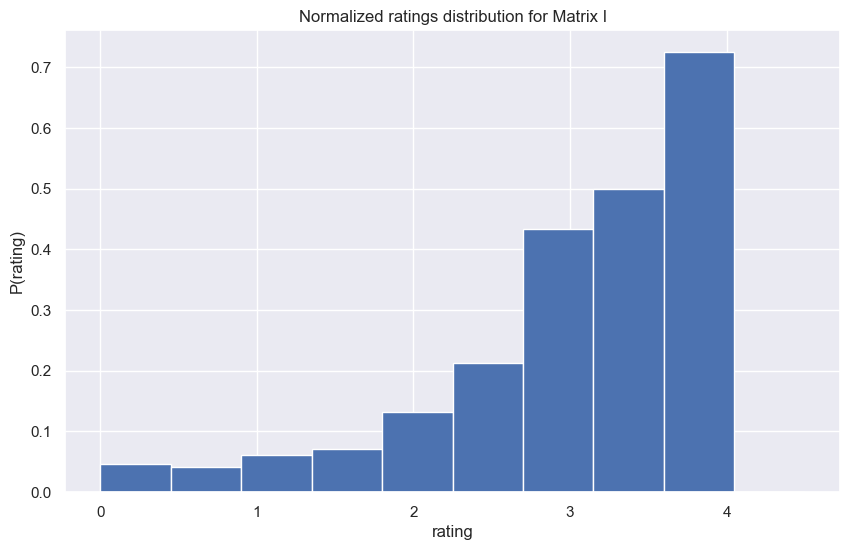

In [5]:
plt.figure(figsize=(10,6))
plt.hist(matrix_1, density=True)
plt.title('Normalized ratings distribution for Matrix I')
plt.xlabel('rating')
plt.ylabel('P(rating)')
plt.show()

#### Pascal's primer (PP) on randomization

More info about RNG: https://numpy.org/doc/stable/reference/random/generator.html

Randomization
As resampling methods draw heavily on the generation of random numbers, it is worth spending some time on understanding the random number generator in Python more deeply. As a reminder, unless you have a hardware random number generator hooked up to your machine the "random" numbers generated by Python are pseudo-random, meaning that they are 100% deterministic, given that you know the following 3 things: 

A. A method to generate them. Most of the computational packages do something that involves the multiplication of large prime numbers (Mersenne primes, usually). This generates a large sequence of digits that distribute randomly (have a random sequence) - as far as we can tell. If this is too complicated, you could use pi (the digits after the period, and you can compute as many as you want). 

B. A starting point in the sequence. Where in - if we use pi - you start getting your digits. This starting point is called the "seed" of the random number generator.   

C. A "state" - the state is the current position in the sequence. Every time we ask Python to generate random number of some sort (interacting with a function that calls the RNG), the state is updated. So if you don't re-initialize the seed, you won't get the same numbers, if you call the same function again, because the *state* has been updated.  

For all intents and purposes - unless you need to investigate randomness itself - your prime concern should be the *seed*. Everything else is handled by experts or Python itself. So focus on the seed.

General statement about the seed: 

You can pick whichever number you want. Importantly, what matters most is that it is *the same* seed if you want the same random sequence. This matters tremendously if you use this - for instance for a train/test split. At random. If you always use the exact same seed, then it will always be the exact same split. Sometimes you want that. For instance, if you store the seed, you can reproduce everything you did. For instance, if you run an experiment, you might want to present your stimuli or conditions at random, for each user. So that there are no carry-over effects (say you study emotional reactions to images, if you always use the same sequence, you could get fatigue effects - or other serial position effects (learning, etc.)). If you forget to store the sequence in which you presented the stimuli (!) you are out luck, unless you stored the seed. From the seed alone, you can completely recreate the sequence that was used for each user. It's also good for professors because if - say in the capstone - I ask you to seed with your student ID and the right answers (e.g. train/test split) are keyed to that seed, it makes plagiarism basically impossible. Because the right answer depends on your seed. 

In Python, if you do not explicitly set a seed, it will by default (under the hood) call the seed method of random without an argument, so this is what happens anyway. And that's fine. Unless you want to know what seed it was or if you want to port code from Python to another language. If you're ok with always getting different numbers in Python, but don't set the seed, and port this code to MATLAB the default seed is the number "0". Unless specified otherwise, MATLAB always seeds with 0. R and Julia have other defaults. So check that before you assume anything. So for something like an experiment, where each sequence of numbers looks random, but it is always the exact same random sequence if we re-use the seed, most experimenters seed the RNG with the user number or the participant number. Using consecutive user numbers (assuming they are unique) is fine as consecutive seed numbers don't produce consecutive random numbers. Seed number doesn't map on the random numbers produced. So from the perspective of the user (you), what really matters is seed management. And for all intents and purposes the only thing that matters there is whether a seed is the same or different and to store it, if you want to recreate what happened. Just to be clear: The random library ("module") contains many other nice functions to get random numbers in addition to the randint function, which draws random integers between the start and end number (inclusive).

#### Bootstrap resampling by hand

In [6]:
matrix_1_mean = np.mean(matrix_1)
print('Matrix I:', matrix_1_mean.round(3))
matrix_2_mean = np.mean(matrix_2)
print('Matrix II:', matrix_2_mean.round(3))
matrix_3_mean = np.mean(matrix_3)
print('Matrix III:', matrix_3_mean.round(3))

Matrix I: 3.119
Matrix II: 2.349
Matrix III: 2.215


In [7]:
ratings_array = matrix_1
num_experiments = int(1e4)
n_samples = len(data)
rng = np.random.default_rng(69420)
bootstrapped_means = []
for i in range(num_experiments):
    random_idx = rng.integers(low=0, high=len(ratings_array), size=n_samples)
    bootstrapped_means.append(ratings_array[random_idx].mean())

In [7]:
#confidence_level = 0.95
#sorted_data = np.sort(bootstrapped_means)
#lower_percentile = (1 - confidence_level)/2
#upper_percentile = 1 - lower_percentile
#lower_index = int(lower_percentile*num_experiments)
#upper_index = num_experiments - lower_index
#lower_bound = sorted_data[lower_index]
#upper_bound = sorted_data[upper_index]

In [8]:
lower_bound = np.sort(bootstrapped_means)[int(.025*len(bootstrapped_means))]
upper_bound = np.sort(bootstrapped_means)[int(.975*len(bootstrapped_means))]

In [9]:
print('Estimate offset:', np.mean(bootstrapped_means) - np.mean(ratings_array))

Estimate offset: 0.00014050239903884432


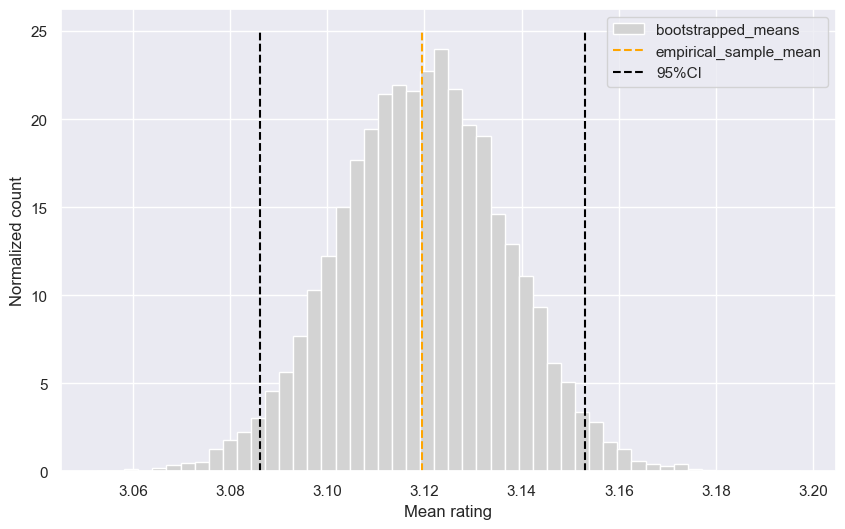

In [10]:
plt.figure(figsize=(10,6))
plt.hist(bootstrapped_means, bins=50, density=True, color='lightgrey', label='bootstrapped_means')
plt.vlines(np.mean(ratings_array), 0, 25, color='orange', ls='--', label='empirical_sample_mean')
plt.vlines(lower_bound, 0, 25, color='black', ls='--', label='95%CI')
plt.vlines(upper_bound, 0, 25, color='black', ls='--')
plt.xlabel('Mean rating')
plt.ylabel('Normalized count')
plt.legend()
plt.show()

#### Bootstrap resampling with SciPy

In [11]:
# input data has to be a sequence
bootstrap_ci = bootstrap((list(ratings_array),), np.mean, n_resamples = int(1e4), 
                         random_state=69420, confidence_level=0.95)
bootstrap_ci

BootstrapResult(confidence_interval=ConfidenceInterval(low=3.0786402749906756, high=3.158265576076971), standard_error=0.02031112286604718)

#### Permutation test by hand

In [12]:
test_stat = np.mean(matrix_2) - np.mean(matrix_3)
test_stat

0.1335042960055528

In [13]:
num_reps = int(1e4)
joint_data = np.concatenate((matrix_2, matrix_3))
n1 = len(matrix_2)
n2 = len(joint_data)
rng = np.random.default_rng(69420)
shuffled_stats = []
for i in range(num_reps):
    shuffled_indices = rng.permutation(n2)
    shuffled_group_1 = joint_data[shuffled_indices[:n1]]
    shuffled_group_2 = joint_data[shuffled_indices[n1:]]
    shuffled_stats.append(np.mean(shuffled_group_1) - np.mean(shuffled_group_2))

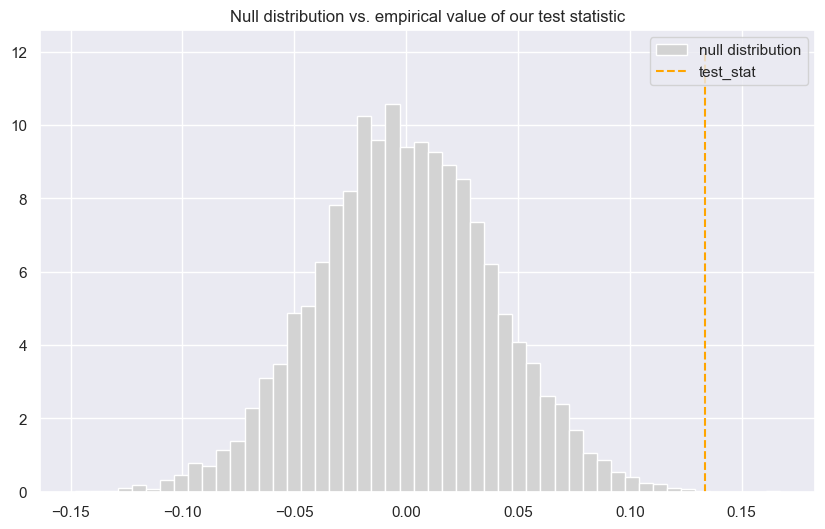

In [14]:
plt.figure(figsize=(10,6))
plt.hist(shuffled_stats, bins=50, density=True, color='lightgrey', label='null distribution')
plt.vlines(test_stat, 0, 12, color='orange', ls='--', label='test_stat')
plt.title('Null distribution vs. empirical value of our test statistic')
plt.legend()
plt.show()

In [15]:
p_val = len(np.argwhere(shuffled_stats>=test_stat))/num_reps
print('p-val:', p_val)

p-val: 0.0002


#### Permutation test with SciPy

In [16]:
def test_stat_func(x,y):
    return np.mean(x) - np.mean(y)
test_data = (matrix_2, matrix_3)
p_test = permutation_test(test_data, test_stat_func, n_resamples=int(1e4), random_state=69420)    
print('Test stat:', p_test.statistic)
print('P-val:',p_test.pvalue)

NameError: name 'permutation_test' is not defined